Analysis of TOPAS-nBio simulations of cells with nanoparticles

This notebook analyses the results of the simulations of TOPAS and TOPAS-nbio of cells with nanoparticles irradiated with I125 radiation source.

In [1]:
import sys
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

# Import our custom modules
from dnadamage_phsp_manager import *
import sddparser
from chemistry_output_manager import *
from phsp_manager import count_phsp_particles
from topas_statistics import TOPASStatistics
from collections import defaultdict
from topas_csv_files_manager import process_csv_file, process_original_hists

## Notebook Functions

This notebook processes the results of multiple TOPAS simulations of cells with nanoparticles. It uses the following imported functions:

- `process_csv_file`: Processes TOPAS CSV files and extracts sum values and histories
- `process_original_hists`: Extracts history values from TOPAS simulation files
- `count_phsp_particles`: Counts particles in phase space files

These functions are organized in the appropriate module files:
- `topas_csv_files_manager.py`: Contains functions for processing TOPAS CSV files
- `phsp_manager.py`: Contains functions for processing phase space files

The notebook processes multiple runs and aggregates results for:
- Original histories
- Dose to nucleus (physical and chemical phases)
- Energy deposited in the cell
- Nanoparticle electron emissions

In [2]:
from analize_cell_sim_results import multirun_processing

# Set parameters for multirun processing
nruns = 100
filebase = '../TOPAS_CellsNPs/work/only_results_CellColony-med1-cell1/cell1'

# Process all runs and get results
Cell_results = multirun_processing(nruns, filebase)


Processing run 100/100...
Processing complete!


In [3]:
def display_results(results):
    """Display processed results with proper formatting and error reporting."""
    print("\nResults Summary:")
    print("-" * 50)
    
    # Display physical quantities
    print("\nPhysical Quantities:")
    print("-" * 50)
    
    # Display particle counts
    print(f"Original histories: {results['Original_hists']['value']:,}")
    print(f"Nanoparticle electrons: {results['NP_el']['value']:,} particles")
    
    # Display dose and energy measurements
    for key in ['DoseToNucl_ph2', 'DoseToNucl_ph3', 'Ecell']:
        print(f"\n{key}:")
        print(f"  - Value: {results[key]['value']:.6e} ± {results[key]['error']:.6e} (2σ)")
    
    # Display chemical phase results 
    print("\nChemical Phase Results (G-Values):")
    print("-" * 50)
    
    # Sort species by G-Value for better presentation
    species_data = [(species, data['value'], data['error']) 
                   for species, data in results['GValues'].items() 
                   if 'value' in data]
    species_data.sort(key=lambda x: x[1], reverse=True)
    
    for species, value, error in species_data:
        print(f"\n{species}:")
        print(f"  - G-Value: {value:.4f} ± {error:.4f} molecules/100eV (2σ)")
    
    # Display DNA damage results if available
    if 'DNADamage' in results and 'totals' in results['DNADamage']:
        print("\nDNA Damage Results:")
        print("-" * 50)
        
        # Display total events and energy
        if 'total_events' in results['DNADamage']['totals']:
            print(f"\nTotal events: {results['DNADamage']['totals']['total_events']:,}")
        
        if 'energy' in results['DNADamage']['totals']:
            energy_stats = results['DNADamage']['totals']['energy']
            print(f"Total energy deposited: {energy_stats['total_MeV']:.2f} MeV")
        
        # Group and display damage statistics
        damage_groups = {
            'Double Strand Breaks (DSBs)': ['DSBs', 'DSBs_Direct', 'DSBs_Indirect', 'DSBs_Hybrid'],
            'Single Strand Breaks (SSBs)': ['SSBs', 'SSBs_Direct', 'SSBs_QuasiDirect', 'SSBs_Indirect'],
            'Strand Breaks (SBs)': ['SBs', 'SBs_Direct', 'SBs_QuasiDirect', 'SBs_Indirect'],
            'Base Damage (BDs)': ['BDs', 'BDs_Direct', 'BDs_QuasiDirect', 'BDs_Indirect'],
            'Complex Damage': ['SSB+s', 'DSB+s', 'More complex damages'],
            'Foci': ['Foci_150nm', 'Foci_500nm']
        }
        
        for group_name, damage_types in damage_groups.items():
            relevant_types = [dt for dt in damage_types if dt in results['DNADamage']['totals']]
            if relevant_types:
                print(f"\n{group_name}:")
                for damage_type in relevant_types:
                    total = results['DNADamage']['totals'][damage_type]
                    print(f"  - {damage_type}: {total:.0f}")


Results Summary:
--------------------------------------------------

Physical Quantities:
--------------------------------------------------
Original histories: 60,000,000
Nanoparticle electrons: 3,707 particles

DoseToNucl_ph2:
  - Value: 2.974897e+00 ± 3.099046e-07 (2σ)

DoseToNucl_ph3:
  - Value: 3.279188e+00 ± 6.724094e-07 (2σ)

Ecell:
  - Value: 2.076337e+01 ± 1.545386e-06 (2σ)

Chemical Phase Results (G-Values):
--------------------------------------------------

H3O^1:
  - G-Value: 3.9077 ± 1.1442 molecules/100eV (2σ)

OH^0:
  - G-Value: 3.5101 ± 1.1790 molecules/100eV (2σ)

e_aq^-1:
  - G-Value: 2.8639 ± 0.7139 molecules/100eV (2σ)

H2O2^0:
  - G-Value: 1.5420 ± 0.5735 molecules/100eV (2σ)

H^0:
  - G-Value: 1.3234 ± 0.5504 molecules/100eV (2σ)

H_2^0:
  - G-Value: 1.2868 ± 0.5948 molecules/100eV (2σ)

OH^-1:
  - G-Value: 1.2106 ± 0.5482 molecules/100eV (2σ)

DNA Damage Results:
--------------------------------------------------

Total events: 1,055
Total energy deposited: 7.7

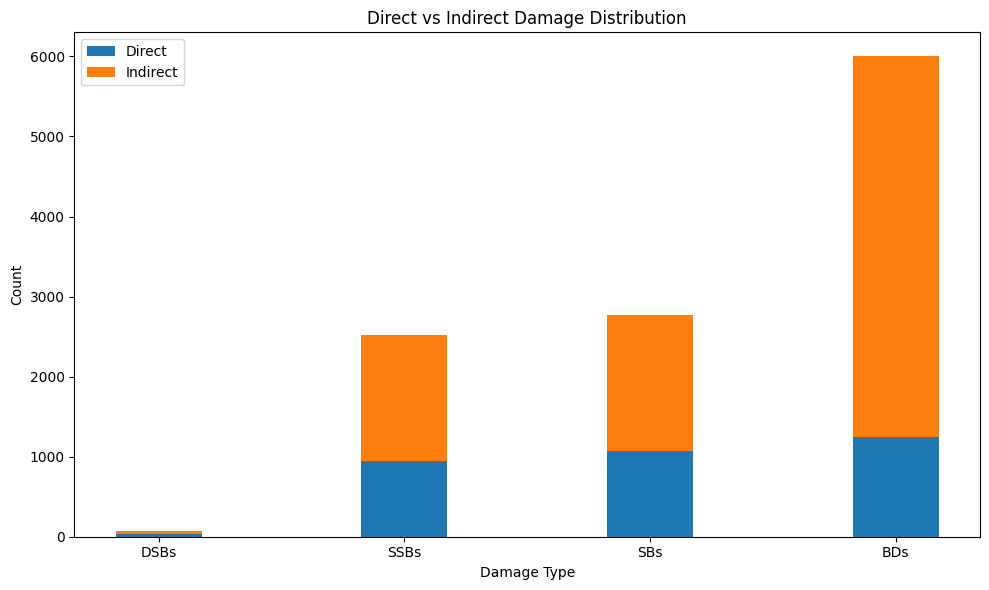

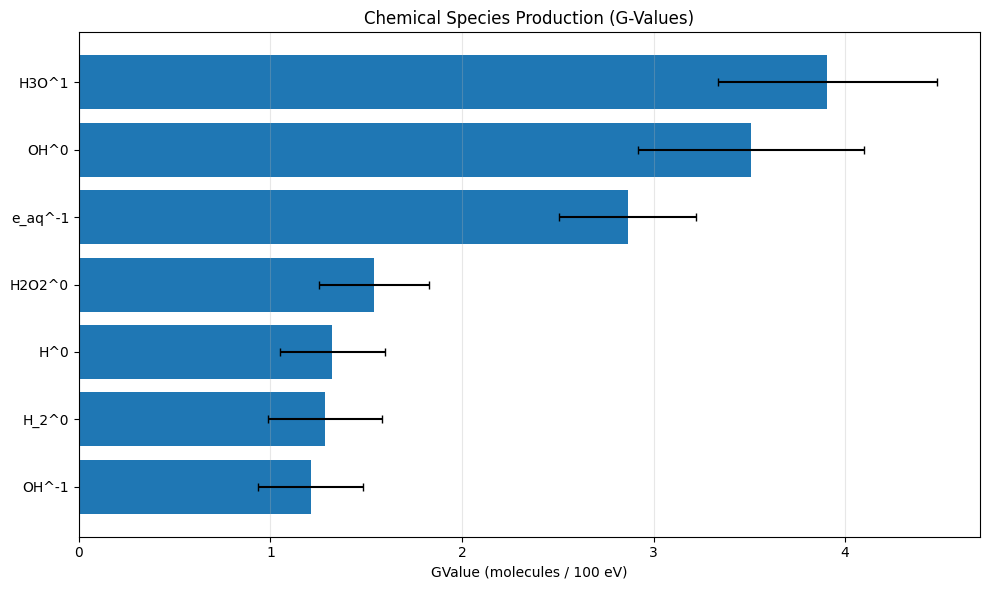

In [4]:
def plot_damage_distribution(damage_totals):
    """Create a stacked bar plot showing direct vs indirect damage distribution."""
    damage_pairs = [
        ('DSBs_Direct', 'DSBs_Indirect'),
        ('SSBs_Direct', 'SSBs_Indirect'),
        ('SBs_Direct', 'SBs_Indirect'),
        ('BDs_Direct', 'BDs_Indirect')
    ]
    
    valid_pairs = [(direct, indirect) for direct, indirect in damage_pairs 
                  if direct in damage_totals and indirect in damage_totals]
    
    if valid_pairs:
        plt.figure(figsize=(10, 6))
        bar_width = 0.35
        x = np.arange(len(valid_pairs))
        labels = [pair[0].split('_')[0] for pair in valid_pairs]
        
        # Plot stacked bars with consistent colors
        direct_color = '#1f77b4'  # blue
        indirect_color = '#ff7f0e'  # orange
        for i, (direct, indirect) in enumerate(valid_pairs):
            direct_sum = damage_totals[direct]
            indirect_sum = damage_totals[indirect]
            plt.bar(i, direct_sum, bar_width, color=direct_color, label='Direct' if i == 0 else "")
            plt.bar(i, indirect_sum, bar_width, bottom=direct_sum, color=indirect_color, label='Indirect' if i == 0 else "")
        
        plt.xlabel('Damage Type')
        plt.ylabel('Count')
        plt.title('Direct vs Indirect Damage Distribution')
        plt.xticks(x, labels)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Create plot of G-values
def plot_gvalues(gvalue_results):
    """Create a horizontal bar plot showing G-values for chemical species."""
    # Convert results to dataframe format
    data = {
        'Species': [],
        'GValue': [],
        'Error': []
    }
    
    for species, result in gvalue_results.items():
        if 'value' in result:
            data['Species'].append(species)
            data['GValue'].append(result['value'])
            data['Error'].append(result['error'] / 2)  # Convert from 2σ to 1σ for error bars
    
    # Convert to DataFrame and sort by GValue
    df = pd.DataFrame(data)
    df = df.sort_values('GValue')
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        df['Species'],
        df['GValue'],
        xerr=df['Error'],
        align='center',
        ecolor='black',
        capsize=3
    )
    
    plt.xlabel('GValue (molecules / 100 eV)')
    plt.title('Chemical Species Production (G-Values)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# Display the results
display_results(Cell_results)

# Plot damage distribution if DNA damage data is available
if 'DNADamage' in Cell_results and 'totals' in Cell_results['DNADamage']:
    plot_damage_distribution(Cell_results['DNADamage']['totals'])

# Plot G-values if chemical species data is available    
if any('value' in data for data in Cell_results['GValues'].values()):
    plot_gvalues(Cell_results['GValues'])

## Multi-Cell Analysis

This section demonstrates processing multiple cells and computing statistics across them.

In [5]:
def plot_chemical_species_violin(all_cell_results):
    """Create violin plot for chemical species G-values across cells."""
    # Prepare data
    species_data = defaultdict(list)
    for cell_results in all_cell_results:
        for species, data in cell_results['GValues'].items():
            species_data[species].append(data['value'])
    
    # Convert to DataFrame and create violin plot
    df = pd.DataFrame(species_data)
    
    plt.figure(figsize=(12, 6))
    vplot = plt.violinplot([df[col].values for col in df.columns], 
                          showmeans=True, showmedians=True)
    
    # Customize violin plot
    plt.xticks(range(1, len(df.columns) + 1), df.columns, rotation=45)
    plt.ylabel('G-Value (molecules/100eV)')
    plt.title('Distribution of G-Values Across Cells')
    
    plt.grid(True, alpha=0.3, axis='y')
    
    # Color the violins
    for pc in vplot['bodies']:
        pc.set_facecolor('#1f77b4')
        pc.set_alpha(0.7)
    
    plt.tight_layout()
    plt.show()

def plot_dna_damage_violin(all_cell_results):
    """Create violin plot for DNA damage across cells."""
    # Define damage types and their attributes
    damage_types = {
        'DSBs': {'color': '#1f77b4', 'label': 'Double Strand Breaks'},
        'SSBs': {'color': '#ff7f0e', 'label': 'Single Strand Breaks'},
        'SBs': {'color': '#2ca02c', 'label': 'Strand Breaks'},
        'BDs': {'color': '#d62728', 'label': 'Base Damage'}
    }
    
    # Collect data
    damage_data = defaultdict(list)
    for cell_results in all_cell_results:
        for damage_type in damage_types.keys():
            damage_data[damage_type].append(cell_results['DNADamage']['totals'][damage_type])
    
    # Create plot
    plt.figure(figsize=(10, 6))
    df = pd.DataFrame(damage_data)
    
    # Create violin plot
    vplot = plt.violinplot([df[col].values for col in df.columns], 
                          showmeans=True, showmedians=True)
    
    # Customize plot
    plt.xticks(range(1, len(df.columns) + 1), 
              [damage_types[col]['label'] for col in df.columns])
    plt.ylabel('Number of Events')
    plt.title('Distribution of DNA Damage Events Across Cells')
    
    # Color the violins
    for i, pc in enumerate(vplot['bodies']):
        damage_type = list(damage_types.keys())[i]
        pc.set_facecolor(damage_types[damage_type]['color'])
        pc.set_alpha(0.7)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def display_multicell_results(all_cell_results, multicell_stats):
    """Display comprehensive results from multicell analysis including tables and plots.
    
    Args:
        all_cell_results: List of results from each cell
        multicell_stats: Aggregated statistics across cells
    """
    # Create DataFrame with results table
    data = []

    # Define all columns
    columns = [
        'Cell',
        'DoseToNucl_ph2 (Gy)', 
        'DoseToNucl_ph3 (Gy)',
        'Energy to Cell (MeV)',
        'NP electrons',
        'DSBs', 'SSBs', 'SBs', 'BDs'
    ]

    # Add G-Value columns for each species
    species_list = list(all_cell_results[0]['GValues'].keys())
    gvalue_columns = [f'G({species})' for species in species_list]
    columns.extend(gvalue_columns)

    # Collect data for each cell
    for i, cell_results in enumerate(all_cell_results):
        row = [
            f'Cell {i+1}',
            cell_results['DoseToNucl_ph2']['value'],
            cell_results['DoseToNucl_ph3']['value'],
            cell_results['Ecell']['value'],
            cell_results['NP_el']['value'],
            cell_results['DNADamage']['totals']['DSBs'],
            cell_results['DNADamage']['totals']['SSBs'],
            cell_results['DNADamage']['totals']['SBs'],
            cell_results['DNADamage']['totals']['BDs']
        ]
        # Add G-Values
        for species in species_list:
            row.append(cell_results['GValues'][species]['value'])
        data.append(row)

    # Add mean values row
    mean_row = [
        'Mean',
        multicell_stats['DoseToNucl_ph2']['mean'],
        multicell_stats['DoseToNucl_ph3']['mean'],
        multicell_stats['Ecell']['mean'],
        multicell_stats['NP_el']['mean'],
        multicell_stats['DNADamage']['totals']['DSBs']['mean'],
        multicell_stats['DNADamage']['totals']['SSBs']['mean'],
        multicell_stats['DNADamage']['totals']['SBs']['mean'],
        multicell_stats['DNADamage']['totals']['BDs']['mean']
    ]
    # Add G-Value means
    for species in species_list:
        mean_row.append(multicell_stats['GValues'][species]['mean'])
    data.append(mean_row)

    # Add standard deviation row
    std_row = [
        'Std Dev',
        multicell_stats['DoseToNucl_ph2']['std_dev'],
        multicell_stats['DoseToNucl_ph3']['std_dev'],
        multicell_stats['Ecell']['std_dev'],
        multicell_stats['NP_el']['std_dev'],
        multicell_stats['DNADamage']['totals']['DSBs']['std_dev'],
        multicell_stats['DNADamage']['totals']['SSBs']['std_dev'],
        multicell_stats['DNADamage']['totals']['SBs']['std_dev'],
        multicell_stats['DNADamage']['totals']['BDs']['std_dev']
    ]
    # Add G-Value standard deviations
    for species in species_list:
        std_row.append(multicell_stats['GValues'][species]['std_dev'])
    data.append(std_row)

    # Create DataFrame and format display
    results_df = pd.DataFrame(data, columns=columns)

    # Format numbers with appropriate precision
    def format_value(x):
        # Handle integers for specific columns
        if isinstance(x, (int, np.integer)) or (isinstance(x, float) and x.is_integer()):
            return '{:d}'.format(int(x))
        # Handle other floats
        if isinstance(x, float):
            if abs(x) < 1e-4 or abs(x) > 1e4:
                return '{:.2e}'.format(x)
            return '{:.4f}'.format(x)
        return str(x)

    # Convert integer columns to int type
    integer_columns = ['NP electrons', 'DSBs', 'SSBs', 'SBs', 'BDs']
    for col in integer_columns:
        if col in results_df.columns:
            results_df[col] = results_df[col].astype('float').round().astype('Int64')

    pd.set_option('display.float_format', format_value)

    # Create styled DataFrame for display
    styled_df = results_df.style.format(format_value)

    # Add highlights for mean and std rows
    styled_df = styled_df.set_properties(**{
        'background-color': '#f2f2f2'
    }, subset=pd.IndexSlice[results_df.index[-2:], :])

    # Display the table
    display(styled_df)

    # Plot distributions
    plot_chemical_species_violin(all_cell_results)
    plot_dna_damage_violin(all_cell_results)




Processing cell 1/10...
Processing run 100/100...
Processing complete!

Processing cell 2/10...
Processing run 100/100...
Processing complete!

Processing cell 3/10...
Processing run 100/100...
Processing complete!

Processing cell 4/10...
Processing run 100/100...
Processing complete!

Processing cell 5/10...
Processing run 100/100...
Processing complete!

Processing cell 6/10...
Processing run 100/100...
Processing complete!

Processing cell 7/10...
Processing run 100/100...
Processing complete!

Processing cell 8/10...
Processing run 100/100...
Processing complete!

Processing cell 9/10...
Processing run 100/100...
Processing complete!

Processing cell 10/10...
Processing run 100/100...
Processing complete!

All cells processed!


,Cell,DoseToNucl_ph2 (Gy),DoseToNucl_ph3 (Gy),Energy to Cell (MeV),NP electrons,DSBs,SSBs,SBs,BDs,G(OH^-1),G(H2O2^0),G(e_aq^-1),G(H^0),G(H3O^1),G(OH^0),G(H_2^0)
0,Cell 1,2.9112,3.0361,19.4407,0,100,2399,2599,5620,0.9480,1.2845,3.5987,1.0959,4.1617,3.7099,0.9846
1,Cell 2,2.9097,2.8671,19.1737,0,99,2180,2378,5342,2.6165,2.5874,5.1906,2.5662,7.4935,6.5081,2.1198
2,Cell 3,2.8168,2.8285,18.7245,0,107,2310,2524,5266,0.9921,1.3534,2.6065,1.1074,3.4815,3.0146,1.0624
3,Cell 4,2.8809,2.9055,18.7468,0,102,2245,2449,5319,0.9798,1.3533,2.6907,1.1200,3.5535,3.0952,1.0540
4,Cell 5,2.6731,2.9137,18.1798,0,109,2256,2474,5553,2.3434,2.7041,4.2912,2.3362,6.4204,5.2960,2.1455
5,Cell 6,2.9093,2.9102,18.6851,0,98,2341,2537,5323,7.1396,13.1693,19.2896,12.4715,25.8314,22.9859,9.0806
6,Cell 7,2.8566,2.9872,18.8210,0,110,2355,2575,5427,0.9237,1.2737,2.6134,1.0364,3.4075,2.9545,0.9909
7,Cell 8,2.9161,2.8379,19.2602,0,103,2158,2364,5192,1.0962,1.4810,3.1104,1.2415,4.0817,3.5589,1.1469
8,Cell 9,3.0633,2.8880,19.5372,0,96,2218,2410,5286,1.2126,1.5848,3.4932,1.2920,4.5681,3.9660,1.2441
9,Cell 10,2.8431,3.1057,19.1927,0,124,2485,2733,5645,0.9294,1.2456,2.6439,1.0597,3.4693,3.0167,0.9542


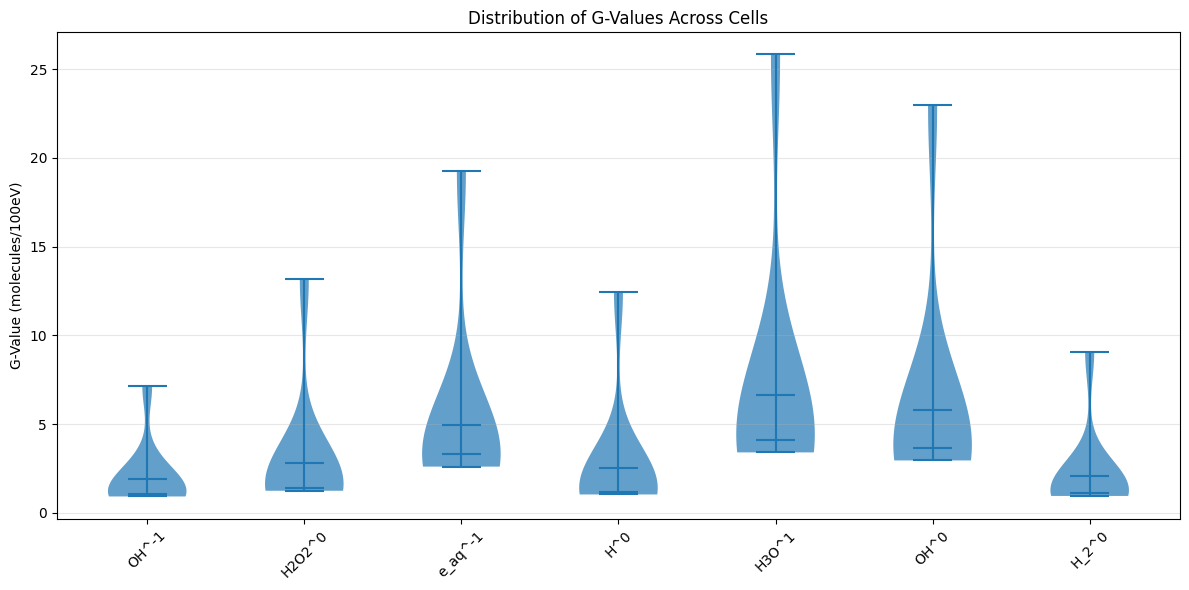

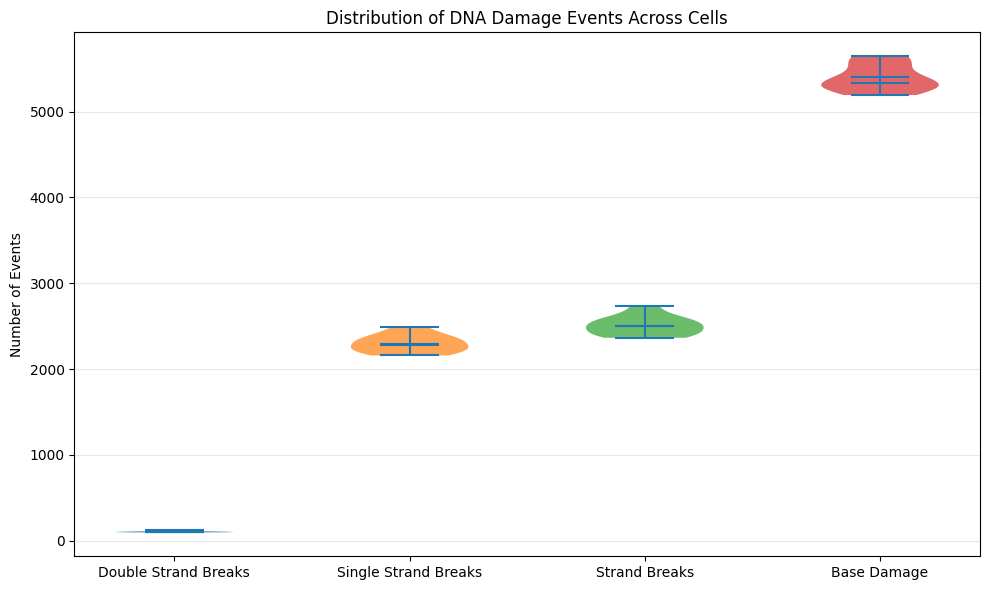

In [6]:
# Process conditions without nanoparticles
from analize_cell_sim_results import multicell_processing, process_multicell_results

# Set parameters for multicell processing
n_cells = 10  # Number of cells to process
n_runs = 100  # Number of runs per cell
base_dir = '../TOPAS_CellsNPs/work/only_results_CellColony-med0-cell0'  # Base directory containing cell directories

# Process all cells and their runs
all_cell_results_med0_cell0 = multicell_processing(n_cells, n_runs, base_dir)

# Compute statistics across cells
multicell_stats_med0_cell0 = process_multicell_results(all_cell_results_med0_cell0)

# Display results for condition without nanoparticles
display_multicell_results(all_cell_results_med0_cell0, multicell_stats_med0_cell0)


Processing cell 1/10...
Processing run 100/100...
Processing complete!

Processing cell 2/10...
Processing run 100/100...
Processing complete!

Processing cell 3/10...
Processing run 100/100...
Processing complete!

Processing cell 4/10...
Processing run 100/100...
Processing complete!

Processing cell 5/10...
Processing run 100/100...
Processing complete!

Processing cell 6/10...
Processing run 100/100...
Processing complete!

Processing cell 7/10...
Processing run 100/100...
Processing complete!

Processing cell 8/10...
Processing run 100/100...
Processing complete!

Processing cell 9/10...
Processing run 100/100...
Processing complete!

Processing cell 10/10...
Processing run 100/100...
Processing complete!

All cells processed!


,Cell,DoseToNucl_ph2 (Gy),DoseToNucl_ph3 (Gy),Energy to Cell (MeV),NP electrons,DSBs,SSBs,SBs,BDs,G(OH^-1),G(H2O2^0),G(e_aq^-1),G(H^0),G(H3O^1),G(OH^0),G(H_2^0)
0,Cell 1,2.9749,3.2792,20.7634,3707,122,2526,2770,6001,1.2106,1.5420,2.8639,1.3234,3.9077,3.5101,1.2868
1,Cell 2,3.1818,3.1311,21.6209,3589,102,2310,2514,5501,0.9907,1.3383,2.6597,1.1305,3.5344,3.0434,1.0230
2,Cell 3,2.9688,3.1335,21.0443,3346,119,2405,2643,5823,0.9482,1.3093,2.6550,1.0307,3.4550,2.9599,1.0205
3,Cell 4,3.2134,3.3100,21.6764,4050,113,2578,2804,5939,0.9430,1.2792,2.5558,1.0511,3.3759,2.9061,0.9903
4,Cell 5,3.2400,3.2949,22.2074,4199,111,2498,2720,5900,0.9489,1.2729,2.6710,1.0674,3.4645,3.0220,0.9924
5,Cell 6,2.7753,2.9654,20.6203,3427,109,2293,2511,5317,1.0389,1.3229,2.7986,1.1155,3.7121,3.2942,1.0756
6,Cell 7,2.9277,3.2554,21.4997,4056,98,2658,2854,5856,1.1080,1.5379,2.8669,1.3182,3.8465,3.4641,1.2415
7,Cell 8,2.9140,3.0708,20.9904,3031,101,2388,2590,5696,2.9489,2.6989,4.4177,3.0369,6.6230,6.7229,2.7048
8,Cell 9,2.9834,3.0680,21.2538,3434,120,2402,2642,5479,1.0029,1.3888,2.7637,1.1338,3.6524,3.1777,1.0860
9,Cell 10,3.0858,3.2862,21.4363,3939,95,2615,2805,6204,1.5092,2.0318,3.6038,1.6223,4.8824,4.3547,1.7114


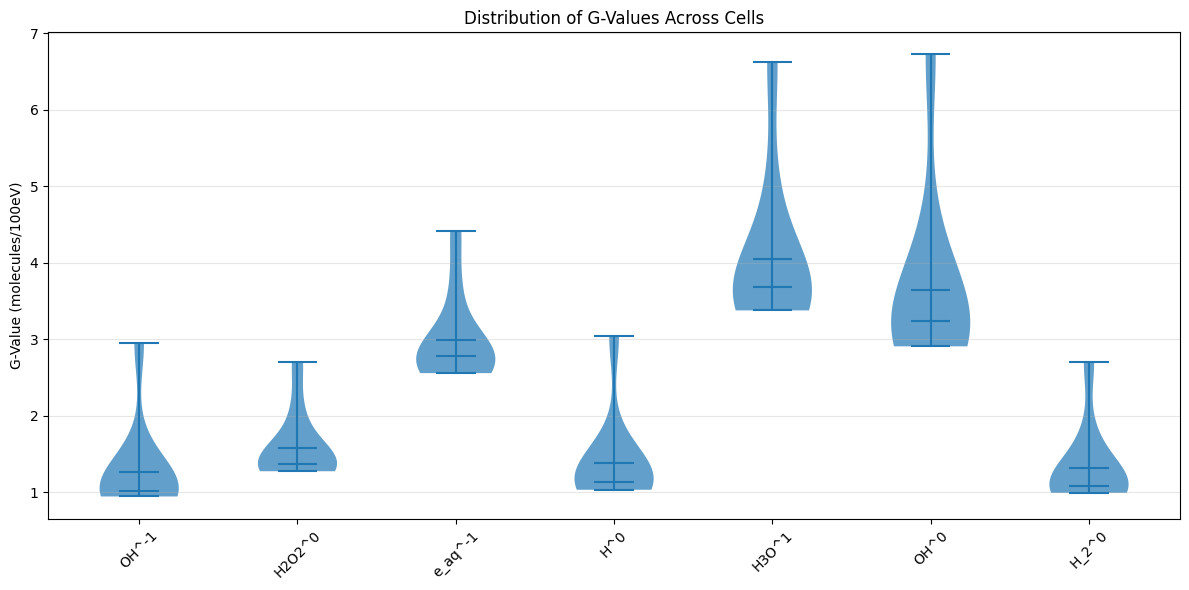

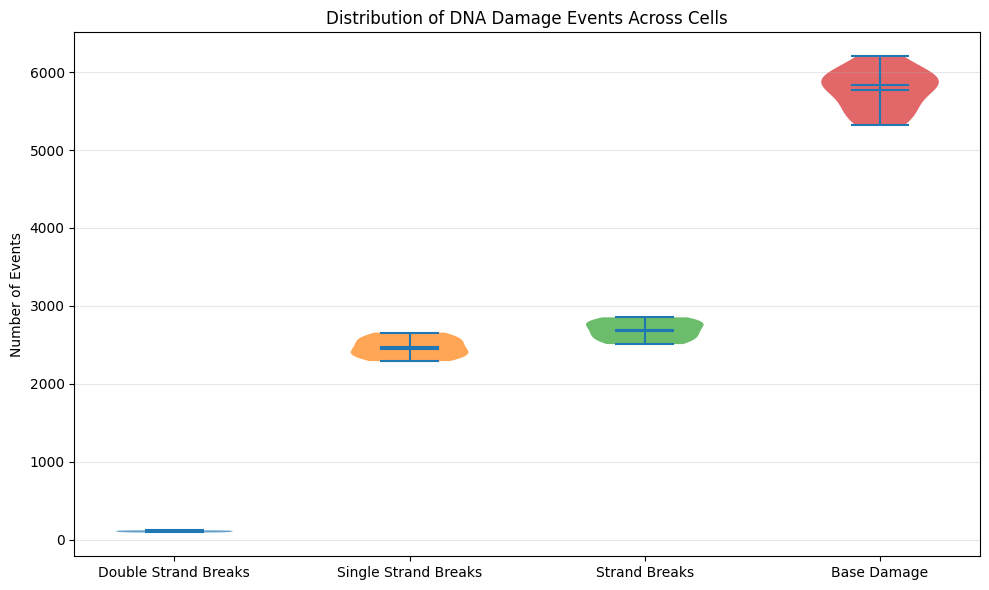

In [7]:
# Cell colony with 1mg NP concentration in medium and cell
base_dir = '../TOPAS_CellsNPs/work/only_results_CellColony-med1-cell1'  # Base directory containing cell directories

# Process all cells and their runs
all_cell_results_med1_cell1 = multicell_processing(n_cells, n_runs, base_dir)

# Compute statistics across cells
multicell_stats_med1_cell1 = process_multicell_results(all_cell_results_med1_cell1)

# Display results for condition without nanoparticles
display_multicell_results(all_cell_results_med1_cell1, multicell_stats_med1_cell1)

## Enhancement Analysis

Compare results between conditions with and without nanoparticles to compute enhancement ratios.

Enhancement Ratios (with NP / without NP)
----------------------------------------


/tmp/ipykernel_57736/3304090420.py:80: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = styled_df.applymap(color_enhancement, subset=['Enhancement Ratio'])


,Quantity,Enhancement Ratio,Uncertainty
0,Dose to Nucleus (Phase 2),1.052,0.063
1,Dose to Nucleus (Phase 3),1.086,0.053
2,Energy to Cell,1.123,0.035
3,Double Strand Breaks,1.040,0.123
4,Single Strand Breaks,1.075,0.073
5,Strand Breaks,1.072,0.069
6,Base Damage,1.069,0.059
7,Energy per event,1.094,0.063
8,G-Value (OH^-1),0.659,2.290
9,G-Value (H2O2^0),0.561,2.288


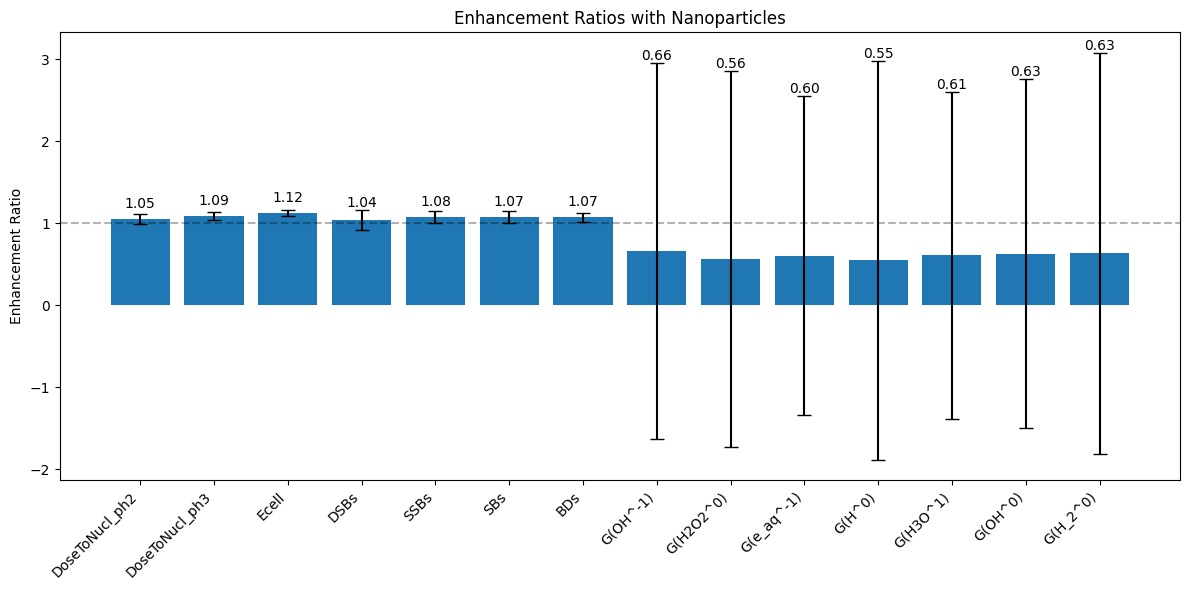

In [8]:
from analize_cell_sim_results import compute_enhancement_ratios

# Get enhancement ratios
enhancement_results = compute_enhancement_ratios(multicell_stats_med1_cell1, multicell_stats_med0_cell0)

# Create enhancement table
def display_enhancement_table(enhancement_results):
    """Display enhancement ratios in a formatted table."""
    data = []
    columns = ['Quantity', 'Enhancement Ratio', 'Uncertainty']
    
    # Physical quantities
    for key in ['DoseToNucl_ph2', 'DoseToNucl_ph3', 'Ecell']:
        if key in enhancement_results['simple_quantities']:
            display_name = {
                'DoseToNucl_ph2': 'Dose to Nucleus (Phase 2)',
                'DoseToNucl_ph3': 'Dose to Nucleus (Phase 3)',
                'Ecell': 'Energy to Cell'
            }[key]
            result = enhancement_results['simple_quantities'][key]
            data.append([
                display_name,
                result['ratio'],
                result['uncertainty']
            ])
    
    # DNA Damage
    damage_display = {
        'DSBs': 'Double Strand Breaks',
        'SSBs': 'Single Strand Breaks',
        'SBs': 'Strand Breaks',
        'BDs': 'Base Damage',
        'energy': 'Energy per event'
    }
    
    for damage_type, display_name in damage_display.items():
        if damage_type in enhancement_results['DNADamage']['totals']:
            result = enhancement_results['DNADamage']['totals'][damage_type]
            data.append([
                display_name,
                result['ratio'],
                result['uncertainty']
            ])
    
    # G-Values
    for species in enhancement_results['GValues']:
        result = enhancement_results['GValues'][species]
        data.append([
            f'G-Value ({species})',
            result['ratio'],
            result['uncertainty']
        ])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    
    # Format the ratios and uncertainties
    def format_ratio(x):
        if isinstance(x, float):
            return f"{x:.3f}"
        return str(x)
    
    styled_df = df.style.format({
        'Enhancement Ratio': format_ratio,
        'Uncertainty': format_ratio
    })
    
    # Add coloring based on enhancement (>1 is blue, <1 is red)
    def color_enhancement(val):
        try:
            val = float(val)
            if val > 1:
                return 'color: blue'
            elif val < 1:
                return 'color: red'
        except:
            pass
        return ''
    
    styled_df = styled_df.applymap(color_enhancement, subset=['Enhancement Ratio'])
    
    display(styled_df)

# Display enhancement table
print("Enhancement Ratios (with NP / without NP)")
print("----------------------------------------")
display_enhancement_table(enhancement_results)

# Create a bar plot of the enhancement ratios
plt.figure(figsize=(12, 6))
data = []
labels = []
errors = []

# Collect data for plotting
for category in ['simple_quantities', 'DNADamage', 'GValues']:
    if category == 'simple_quantities':
        for key in ['DoseToNucl_ph2', 'DoseToNucl_ph3', 'Ecell']:
            if key in enhancement_results['simple_quantities']:
                result = enhancement_results['simple_quantities'][key]
                data.append(result['ratio'])
                errors.append(result['uncertainty'])
                labels.append(key)
    elif category == 'DNADamage':
        for key in ['DSBs', 'SSBs', 'SBs', 'BDs']:
            if key in enhancement_results['DNADamage']['totals']:
                result = enhancement_results['DNADamage']['totals'][key]
                data.append(result['ratio'])
                errors.append(result['uncertainty'])
                labels.append(key)
    else:  # GValues
        for species in enhancement_results['GValues']:
            result = enhancement_results['GValues'][species]
            data.append(result['ratio'])
            errors.append(result['uncertainty'])
            labels.append(f'G({species})')

# Create bar plot
x = np.arange(len(labels))
plt.bar(x, data, yerr=errors, capsize=5)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)

# Customize plot
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Enhancement Ratio')
plt.title('Enhancement Ratios with Nanoparticles')

# Add value labels on top of bars
for i, v in enumerate(data):
    plt.text(i, v + max(errors[i], 0.1), f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()